In [1]:
# !pip install datasets
# !pip install sacremoses
# !pip install transformers[torch]
# !pip install torch
# !pip install evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Use the FIQA-PL dataset that was used in lab 1 and lab lab 2 (so we need the passages, the questions and their relations).

In [ ]:
from datasets import load_dataset
import pandas as pd
from transformers import AutoTokenizer, Trainer, pipeline
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pyarrow as pa
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import numpy as np
import evaluate

In [ ]:
dataset = load_dataset("clarin-knext/fiqa-pl", 'corpus')

Generating corpus split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset['corpus']

Dataset({
    features: ['_id', 'title', 'text'],
    num_rows: 57638
})

In [ ]:
queries = load_dataset("clarin-knext/fiqa-pl", 'queries')

Generating queries split: 0 examples [00:00, ? examples/s]

In [ ]:
queries['queries']

Dataset({
    features: ['_id', 'title', 'text'],
    num_rows: 6648
})

In [ ]:
qrels = load_dataset("clarin-knext/fiqa-pl-qrels")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
corpus=pd.DataFrame(dataset['corpus'])
queries=pd.DataFrame(queries['queries'])
qrels=pd.DataFrame(qrels['train'])

In [ ]:
qrels

,query-id,corpus-id,score
0,0,18850,1
1,4,196463,1
2,5,69306,1
3,6,560251,1
4,6,188530,1
...,...,...,...
14161,11096,407726,1
14162,11097,131224,1
14163,11099,424427,1
14164,11099,150878,1


In [ ]:
queries=queries.rename(columns={'_id':'query-id'})
corpus=corpus.rename(columns={'_id':'corpus-id'})
qrels['query-id']=qrels['query-id'].astype(int)
queries['query-id']=queries['query-id'].astype(int)
corpus['corpus-id']=corpus['corpus-id'].astype(int)

In [ ]:
true_df = pd.merge(queries, qrels, on='query-id',suffixes=('_left', '_right'))
true_df = pd.merge(true_df, corpus, on='corpus-id',suffixes=('_left', '_right'))

In [ ]:
true_df=true_df.reset_index(drop=True)
true_df=true_df[['corpus-id','text_right','text_left','score']]
true_df=true_df.rename(columns={'text_right':'question','text_left':'answer'})

In [ ]:
true_df

,corpus-id,question,answer,score
0,18850,Wytyczne IRS dotyczące tematu. Ogólnie rzecz b...,Co jest uważane za wydatek służbowy w podróży ...,1
1,196463,Co do zasady musisz wybrać pomiędzy odliczenie...,Wydatki służbowe - ubezpieczenie samochodu pod...,1
2,69306,"Większość stanów USA ma zasady, które brzmią m...",Rozpoczęcie nowego biznesu online,1
3,560251,"Nie wierzę też, że sobota jest dniem roboczym....",„Dzień roboczy” i „termin płatności” rachunków,1
4,188530,"Zdecydowanie masz argument, aby skłonić ich do...",„Dzień roboczy” i „termin płatności” rachunków,1
...,...,...,...,...
14161,407726,"„Annuity to produkt. Mówiąc prościej, przekazu...","Emerytury, renty i „emerytura”",1
14162,131224,„Firma ubezpieczeniowa akcji jest zbudowana ja...,Co oznacza dla posiadacza polisy na życie prze...,1
14163,424427,Edytowane w odpowiedzi na komentarz JoeTaxpaye...,Czy strata kapitałowa w tradycyjnej IRA i Roth...,1
14164,150878,"Nie, nie możesz. Jeśli wypłacisz wszystko ze w...",Czy strata kapitałowa w tradycyjnej IRA i Roth...,1


In [ ]:
columns = ['question', 'answer', 'score']
false_df = pd.DataFrame(columns=columns)

In [ ]:
import random

not_avaiable_text=set(list(true_df['corpus-id']))
answers=list(set(list(qrels['query-id'])))

for i in range(len(true_df['corpus-id'])):
  corpus_id = random.choice(corpus['corpus-id'])
  while corpus_id in not_avaiable_text:
      corpus_id = random.choice(corpus['corpus-id'])
  answer=random.choice(answers)

  new_row = {
            'question': queries[queries['query-id'] == answer]['text'].values[0],
            'answer': corpus[corpus['corpus-id'] == corpus_id]['text'].values[0],
            'score': 0
        }
  false_df = pd.concat([false_df, pd.DataFrame([new_row])], ignore_index=True)

In [ ]:
false_df

,question,answer,score
0,"Czy właściciel obligacji etf uzyskuje dochód, ...",Jestem zdumiony usługami Ralph Property Financ...,0
1,Ocena wartości ESPP (startup),"„Cóż, jest to bezpośrednie wpłacanie pieniędzy...",0
2,"W jakim kraju mogę założyć małą firmę, aby pła...","> Europa nigdy nie wyda takich kwot, bo to po ...",0
3,"Co dzieje się z pierwotnymi środkami, gdy potw...","Amazon dominuje w sprzedaży internetowej, nie ...",0
4,Czy metale szlachetne/kolekcje są opłacalnym f...,"„Rynek aukcyjny to miejsce, w którym inwestorz...",0
...,...,...,...
14161,W jakich terminach giełdy NYSE i USA są zazwyc...,„Przez większość czasu* sprzedajesz innym inwe...,0
14162,Spam tekstowy „Nakaz rozliczenia zadłużenia” –...,http://www.npr.org/blogs/money/2012/07/19/1570...,0
14163,Jak inflacja w Chinach powoduje wzrost realneg...,"> W rzeczywistości było powszechnie wiadomo, ż...",0
14164,Długoterminowe unikanie zysków kapitałowych,socjalizm ˈsōSHəˌlizəm/ rzeczownik: socjalizm ...,0


In [ ]:
final_df=pd.concat([true_df.sample(n=2000),false_df.sample(n=10000)],axis=0)[['question','answer','score']].sample(frac=1).reset_index(drop=True)

In [ ]:
final_df['text']=final_df.apply(lambda x: f"Pytanie: {x['question']} Kontekst: {x['answer']}", axis=1)

In [ ]:
final_df=final_df[['text','score']]

In [ ]:
final_df

,text,score
0,Pytanie: Czy dochody funduszu obligacji zwolni...,0
1,Pytanie: Dlaczego w maju 2009 r. wskaźnik S&P ...,0
2,Pytanie: Jak straty LLC wpływają na podatki do...,0
3,Pytanie: Skąd inwestorzy giełdowi otrzymują ak...,0
4,Pytanie: Co oznacza „Dystrybucja firmy” w narz...,0
...,...,...
11995,Pytanie: To pytanie jest bardzo otwarte. Ale p...,1
11996,Pytanie: Jakie fundusze zostały zamknięte w tr...,0
11997,Pytanie: Przybliżenie wartości kapitałów własn...,0
11998,Pytanie: Jakie są implikacje programu odkupu a...,0


# The dataset from point 2 should be split into training, evaluation and testing subsets.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')

tokenizer_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/907k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/556k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

In [ ]:
def process_data(row):
    text = row['text']
    text = str(text)
    text = ' '.join(text.split())
    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=128)
    encodings['label'] = row['score']
    encodings['text'] = text

    return encodings

In [ ]:
processed_data = []

for i in range(len(final_df)):
    processed_data.append(process_data(final_df.iloc[i]))

In [ ]:
new_df = pd.DataFrame(processed_data)

In [ ]:
new_df['input_ids'].head(5)

0    [0, 14142, 1335, 3007, 11410, 9704, 20794, 477...
1    [0, 14142, 1335, 5640, 1019, 9809, 3539, 1024,...
2    [0, 14142, 1335, 2912, 7153, 48, 48, 1023, 263...
3    [0, 14142, 1335, 13232, 20327, 6518, 14529, 16...
4    [0, 14142, 1335, 3407, 5601, 1791, 36170, 5739...
Name: input_ids, dtype: object

In [ ]:
train_df, valid_df = train_test_split(new_df,test_size=0.2,random_state=42)
train_df, test_df = train_test_split(train_df,test_size=0.2,random_state=42)

In [ ]:
valid_df['input_ids']

1935     [0, 14142, 1335, 21475, 8588, 1998, 2233, 2264...
6494     [0, 14142, 1335, 1018, 7438, 1998, 2528, 1750,...
1720     [0, 14142, 1335, 13792, 2012, 36513, 33447, 42...
9120     [0, 14142, 1335, 26897, 6652, 11175, 5414, 460...
360      [0, 14142, 1335, 2912, 12684, 19617, 1791, 112...
                               ...                        
1195     [0, 14142, 1335, 1791, 13540, 10234, 6872, 209...
11877    [0, 14142, 1335, 15614, 2220, 1009, 7057, 1992...
5421     [0, 14142, 1335, 7511, 2092, 17477, 17670, 128...
3855     [0, 14142, 1335, 3007, 12772, 7122, 2869, 2546...
4414     [0, 14142, 1335, 3007, 5492, 10746, 11397, 108...
Name: input_ids, Length: 2400, dtype: object

In [ ]:
new_df['label'].unique()

array([0, 1])

In [ ]:
train = Dataset(pa.Table.from_pandas(train_df))
valid = Dataset(pa.Table.from_pandas(valid_df))
test = Dataset(pa.Table.from_pandas(test_df))

In [ ]:
train

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids', '__index_level_0__'],
    num_rows: 7680
})

## Train a text classifier using the Transformers library that distinguishes between the positive and the negative pairs. To make the process manageable use models of size base and a runtime providing GPU/TPU acceleration. Consult the discussions related to fine-tuning Transformer models to select sensible set of parameters. You can also run several trainings with different hyper-parameters, if you have access to large computing resources.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('allegro/herbert-base-cased',num_labels=2)
model

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
arguments = TrainingArguments(
    output_dir="/content/gdrive/MyDrive/output",
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=300,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-05,
    num_train_epochs=10,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch"
    )

trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=train,
    eval_dataset=valid,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

In [ ]:
%load_ext tensorboard
%tensorboard --logdir gdrive/MyDrive/poquad/output/runs

In [ ]:
trainer.train()

You're using a HerbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
300,0.000100,0.003622,0.999583
600,0.006400,0.008385,0.997917
900,0.000000,0.000436,0.999583
1200,0.000000,0.001357,0.999583
1500,0.000000,0.000005,1.000000
1800,0.020600,0.007067,0.999167
2100,0.003300,0.026946,0.997083
2400,0.000000,0.000011,1.000000
2700,0.000000,0.000007,1.000000
3000,0.000000,0.000005,1.000000


TrainOutput(global_step=4800, training_loss=0.0035555552246235795, metrics={'train_runtime': 2160.5622, 'train_samples_per_second': 35.546, 'train_steps_per_second': 2.222, 'total_flos': 5051732262912000.0, 'train_loss': 0.0035555552246235795, 'epoch': 10.0})

## Report the results you have obtained for the model. Use appropriate measures, since the dataset is not balanced.

In [ ]:
trainer.evaluate()

{'eval_loss': 5.834715466335183e-06,
 'eval_accuracy': 1.0,
 'eval_runtime': 22.4474,
 'eval_samples_per_second': 106.916,
 'eval_steps_per_second': 6.682,
 'epoch': 10.0}

In [ ]:
model.save_pretrained('/content/model/')

In [ ]:
text = final_df[final_df['score']==1][5:6]['text'].values[0]
text

'Pytanie: Musisz dowiedzieć się, w jakim formacie MoneyStrands oczekuje danych. Plik .qif lub .ofx może nie być odpowiedzią. Kontekst: Prawidłowe sposoby importowania danych transakcji Personal Finance'

In [ ]:
classifier = pipeline("sentiment-analysis", model="/content/gdrive/MyDrive/output/checkpoint-4800")

classifier(text)

[{'label': 'LABEL_1', 'score': 0.999975323677063}]

# 6. Use the classifier as a re-ranker for finding the answers to the questions. Since the re-ranker is slow, you have to limit the subset of possible passages to top-n (10, 50 or 100 - depending on your GPU) texts returned by much faster model, e.g. FTS.

7. The scheme for re-ranking is as follows:


1.   Find passage candidates using FTS, where the query is the question.
2.   Take top-n results returned by FTS.
3.   Use the model to classify all pairs, where the first sentence is the question (query) and the second sentence is the passage returned by the FTS.
4.   Use the score returned by the model (i.e. the probability of the positive outcome) to re-rank the passages.




In [ ]:
%%capture
!pip install elasticsearch==8.8.0

In [ ]:
%%bash

rm -rf elasticsearch*
wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-8.8.0-linux-x86_64.tar.gz
tar -xzf elasticsearch-8.8.0-linux-x86_64.tar.gz
sudo chown -R daemon:daemon elasticsearch-8.8.0/
umount /sys/fs/cgroup
apt install cgroup-tools

Reading package lists...
Building dependency tree...
Reading state information...
cgroup-tools is already the newest version (2.0-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


umount: /sys/fs/cgroup: not mounted.




In [ ]:
try:
    import os
    import elasticsearch
    from elasticsearch import Elasticsearch
    import numpy as np
    import pandas as pd
    import sys
    import json
    from ast import literal_eval
    from tqdm import tqdm
    import datetime
    from elasticsearch import helpers

except Exception as e:
    print(f"error: {e}")

In [ ]:
%%bash --bg

sudo -H -u daemon elasticsearch-8.8.0/bin/elasticsearch

In [ ]:
!ps -ef | grep elastic

root        3876    3874  0 05:51 ?        00:00:00 sudo -H -u daemon elasticsearch-8.8.0/bin/elasti
daemon      3877    3876 28 05:51 ?        00:00:12 /content/elasticsearch-8.8.0/jdk/bin/java -Xms4m
daemon      3976    3877 99 05:52 ?        00:00:46 /content/elasticsearch-8.8.0/jdk/bin/java -Des.n
daemon      4020    3976  0 05:52 ?        00:00:00 /content/elasticsearch-8.8.0/modules/x-pack-ml/p
root        4191     626  0 05:52 ?        00:00:00 /bin/bash -c ps -ef | grep elastic
root        4193    4191  0 05:52 ?        00:00:00 grep elastic


In [ ]:
!/content/elasticsearch-8.8.0/bin/elasticsearch-plugin install pl.allegro.tech.elasticsearch.plugin:elasticsearch-analysis-morfologik:8.8.0

-> Installing pl.allegro.tech.elasticsearch.plugin:elasticsearch-analysis-morfologik:8.8.0
-> Downloading pl.allegro.tech.elasticsearch.plugin:elasticsearch-analysis-morfologik:8.8.0 from maven central
[=================================================] 100%   
-> Installed analysis-morfologik
-> Please restart Elasticsearch to activate any plugins installed


In [ ]:
%%bash --bg
pkill -f elastic

In [ ]:
%%bash --bg

sudo -H -u daemon elasticsearch-8.8.0/bin/elasticsearch

In [ ]:
#it may take some time before working, elastic search takes some time to load.
!/content/elasticsearch-8.8.0/bin/elasticsearch-setup-passwords auto -url "https://localhost:9200"

******************************************************************************
Note: The 'elasticsearch-setup-passwords' tool has been deprecated. This       command will be removed in a future release.
******************************************************************************

Initiating the setup of passwords for reserved users elastic,apm_system,kibana,kibana_system,logstash_system,beats_system,remote_monitoring_user.
The passwords will be randomly generated and printed to the console.
Please confirm that you would like to continue [y/N]y


Changed password for user apm_system
PASSWORD apm_system = IOpasyiURFOOQzsSn9oJ

Changed password for user kibana_system
PASSWORD kibana_system = yCXglLUEuOr0gGPSEYFz

Changed password for user kibana
PASSWORD kibana = yCXglLUEuOr0gGPSEYFz

Changed password for user logstash_system
PASSWORD logstash_system = vuC0dNYamzH36UsEeJ87

Changed password for user beats_system
PASSWORD beats_system = Rlf5kDvQeZuDPXy05Xc2

Changed password for user rem

In [ ]:
!curl --cacert /content/elasticsearch-8.8.0/config/certs/http_ca.crt -u elastic -H 'Content-Type: application/json' -XGET https://localhost:9200/?pretty=true

Enter host password for user 'elastic':
{
  "name" : "3364e237a98a",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "-GABD5ZdSRamRkTCLNSd5A",
  "version" : {
    "number" : "8.8.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "c01029875a091076ed42cdb3a41c10b1a9a5a20f",
    "build_date" : "2023-05-23T17:16:07.179039820Z",
    "build_snapshot" : false,
    "lucene_version" : "9.6.0",
    "minimum_wire_compatibility_version" : "7.17.0",
    "minimum_index_compatibility_version" : "7.0.0"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
username = 'elastic'
password = 'pkKwri9P9bR8BJSwaQxW'
es = Elasticsearch(['https://localhost:9200'], basic_auth=(username, password), ca_certs="/content/elasticsearch-8.8.0/config/certs/http_ca.crt")
resp = dict(es.info())
resp

{'name': '3364e237a98a',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': '-GABD5ZdSRamRkTCLNSd5A',
 'version': {'number': '8.8.0',
  'build_flavor': 'default',
  'build_type': 'tar',
  'build_hash': 'c01029875a091076ed42cdb3a41c10b1a9a5a20f',
  'build_date': '2023-05-23T17:16:07.179039820Z',
  'build_snapshot': False,
  'lucene_version': '9.6.0',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

In [ ]:
analyzer = {
    "mappings": {
        "properties": {
            "text": {
                "type": "text",
                "analyzer": "polish_analyzer"
             },
        }
    },
    "settings": {
        "analysis": {
            "analyzer": {
                "polish_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter": ["lowercase", "morfologik_stem", "lowercase"]
                }
            }
        }
    }
}

# 8. Compute how much the result of searching the passages improved over the results from lab 2. Use NDCG to compare the results.

In [ ]:
def calc_ndcg_k(scores):
    dcg = np.sum(scores / np.log2(np.arange(2, len(scores) + 2)))
    idcg = np.sum(sorted(scores, reverse=True) / np.log2(np.arange(2, len(scores) + 2)))
    ndcg = dcg / idcg if idcg > 0 else 0.0
    return ndcg

In [ ]:
i=0

for record in corpus['text']:
    document = {
        "text": record,
    }
    es.index(index="analyzer", id=i, document=document)
    i=i+1

In [ ]:
query_blank = {
        "match": {
            "text":{
                "query":"blank"
            }
        }
    }

In [ ]:
df_qa_test = load_dataset("clarin-knext/fiqa-pl-qrels")
df_qa_test = pd.DataFrame(df_qa_test['test'])

In [ ]:
query = queries['text'][113]
query

'Jak mieć małą lokatę kapitału w USA, jeśli jestem poza krajem?'

In [ ]:
query_blank['match']['text']['query'] = query

In [ ]:
resp = es.search(index="analyzer", query=query_blank)

In [ ]:
data = []
for val in resp['hits']['hits'][:10]:
  data.append(f"Pytanie: {query} Kontekst: {val['_source']['text']}")

data_df = pd.DataFrame(data, columns=['text'])

In [ ]:
rank = {}
for i, text in enumerate(data):
  text = text[:512]
  rank[i] = classifier(text)

In [ ]:
rank.items()

dict_items([(0, [{'label': 'LABEL_0', 'score': 0.9999983310699463}]), (1, [{'label': 'LABEL_0', 'score': 0.9999983310699463}]), (2, [{'label': 'LABEL_0', 'score': 0.9999982118606567}]), (3, [{'label': 'LABEL_0', 'score': 0.9999982118606567}]), (4, [{'label': 'LABEL_0', 'score': 0.9999982118606567}]), (5, [{'label': 'LABEL_0', 'score': 0.9999983310699463}]), (6, [{'label': 'LABEL_0', 'score': 0.9999982118606567}]), (7, [{'label': 'LABEL_0', 'score': 0.9999982118606567}]), (8, [{'label': 'LABEL_0', 'score': 0.9999982118606567}]), (9, [{'label': 'LABEL_0', 'score': 0.999997615814209}])])

In [ ]:
df3 = load_dataset("clarin-knext/fiqa-pl", "queries")
df_queries = pd.DataFrame(df3['queries'])
dataset = load_dataset("clarin-knext/fiqa-pl", 'corpus')
dataset=pd.DataFrame(dataset['corpus'])

In [ ]:
arr = np.array([0.0 for i in range(5)])
ndcg = 0
i = 0

for query_id in df_qa_test['query-id'].unique():
    query = df_queries[df_queries['_id'] == str(query_id)].iloc[0]['text']
    query_blank['match']['text']['query'] = query
    resp = es.search(index="analyzer", query=query_blank)

    data = []
    for val in resp['hits']['hits'][:10]:
      data.append(f"Pytanie: {query} Kontekst: {val['_source']['text']}")

    corpus_ids = df_qa_test[df_qa_test['query-id'] == query_id]['corpus-id']

    tmp = set()
    for ind in corpus_ids:
        _id = dataset[dataset['_id'] == str(ind)].index.tolist()[0]
        tmp.add(_id)

    rank = {}
    for i, text in enumerate(data):
      text = text[:512]
      rank[i] = classifier(text)
    sorted_rank = {k: v for k, v in sorted(rank.items(), key=lambda item: item[1][0]['score'], reverse=True)}
    sorted_5 = {k: sorted_rank[k] for k in list(sorted_rank)[:5]}
    for i, ind in enumerate(sorted_5.keys()):
      val = resp['hits']['hits'][ind]
      _id = np.float64(val['_id'])
      if _id in tmp:
          arr[i] = 3
      else:
          arr[i] = 0
    ndcg += calc_ndcg_k(arr)
    i += 1

In [ ]:
mean_ndcg = ndcg / i
print(f"Mean NDCG with model: {mean_ndcg}")

Mean NDCG with model: 21.477445818797314


Results improved quite a bit, lab 2 had about 14%

# Questions (2 points):

Do you think simpler methods, like Bayesian bag-of-words model, would work for sentence-pair classification? Justify your answer.



I dont think that bayesian BOW would be a good model for this task, mainly because this model can't take semantics,context and complex relationships into account, which was crucial for tasks related to the interpretation of sentence content.

What hyper-parameters you have selected for the training? What resources (papers, tutorial) you have consulted to select these hyper-parameters?

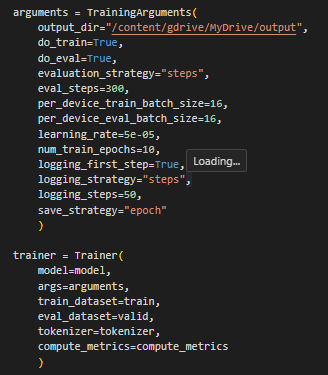

I visited some sites to check the correctness of parameters usage, but mostly i followed huggingface tutorials and skeleton provided in task description.

Think about pros and cons of the neural-network models with respect to natural language processing. Provide at least 2 pros and 2 cons.

pros:


1.   better language processing by taking into account semantic dependencies
2.   possibility of using transfer learning



cons:


1.   Often complicated in interpretation
2.   They require access to high computing power


